In [ ]:
from ultralytics import YOLO
import pandas as pd
import os
from torchvision import transforms
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import shutil
from collections import defaultdict
import json
from pathlib import Path
from tqdm import tqdm
import logging
from typing import List, Dict, Union
import os
from PIL import Image, ImageDraw, ImageFont
from numpy import asarray
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.regularizers import l1_l2
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn import datasets
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dropout,Flatten,Dense,Activation, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam, Adamax
tf.keras.backend.clear_session()
from tensorflow.keras.callbacks import CSVLogger
np.random.seed(200)
# !wandb disabled

import warnings
warnings.filterwarnings("ignore")


0: 224x224 1 person, 2 buss, 343.9ms
Speed: 2.6ms preprocess, 343.9ms inference, 6.2ms postprocess per image at shape (1, 3, 224, 224)


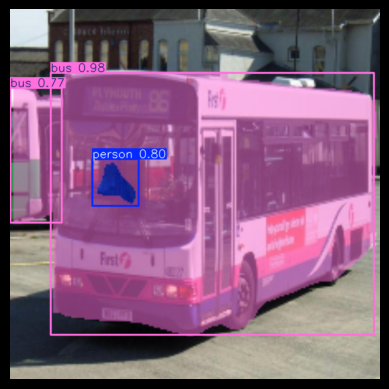

array([[[240, 233, 223],
        [240, 233, 223],
        [240, 233, 223],
        ...,
        [ 64,  67,  58],
        [ 73,  72,  63],
        [ 74,  73,  63]],

       [[240, 233, 223],
        [240, 233, 223],
        [240, 233, 223],
        ...,
        [ 64,  67,  58],
        [ 73,  72,  62],
        [ 74,  73,  63]],

       [[240, 233, 223],
        [240, 233, 223],
        [240, 233, 223],
        ...,
        [ 65,  66,  57],
        [ 74,  71,  61],
        [ 75,  72,  62]],

       ...,

       [[148, 166, 169],
        [148, 166, 169],
        [148, 166, 170],
        ...,
        [156, 185, 188],
        [158, 187, 190],
        [158, 187, 190]],

       [[148, 166, 169],
        [148, 166, 169],
        [148, 166, 170],
        ...,
        [163, 193, 196],
        [165, 196, 199],
        [165, 196, 199]],

       [[148, 166, 169],
        [148, 166, 169],
        [148, 166, 170],
        ...,
        [163, 194, 196],
        [166, 197, 200],
        [166, 197, 200]]

In [2]:
#------------------------
# Method
#------------------------


model = YOLO('yolov8m-seg_best.pt')

def predict_image(img_path):
    # Load the image
    img = cv2.imread(img_path)

    # Perform prediction using the saved model
    detect_result = model(img)

    # Plot the detection results
    detect_img = detect_result[0].plot()

    # Display the image with detections
    plt.imshow(cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    plt.axis('off')  # Hide axes
    plt.show()

    return detect_img

# Test the function
predict_image('00e4cd60e84c0463_jpg.rf.c14f84986360a80ea34f8ae1d2fe822e.jpg')

In [4]:
with open('class_names.json', 'r') as f:
    class_names = json.load(f)
    print(class_names)

['beige', 'black', 'blue', 'brown', 'green', 'grey', 'orange', 'pink', 'purple', 'red', 'white', 'yellow']


In [5]:
isize = 224

In [6]:
train_generator = ImageDataGenerator(
    rescale=1/255.,
    brightness_range=None,
    width_shift_range=0.5,
    rotation_range=False,
    horizontal_flip=True,
    vertical_flip=False
)

valid_generator = ImageDataGenerator(rescale=1/255.)

In [21]:
# test_generator = ImageDataGenerator(rescale=1./255)

In [7]:
train_df = pd.read_csv('train_df.csv')
valid_df = pd.read_csv('valid_df.csv')
test_df = pd.read_csv('test_df.csv')

In [8]:
train_df.shape, valid_df.shape, test_df.shape

((7267, 3), (1550, 3), (1556, 3))

In [9]:
display(train_df.head())
display(valid_df.head())
display(test_df.head())

,label,idfiles,id
0,orange,2cc754bf26.jpg,../input/vcor-vehicle-color-recognition-datase...
1,orange,a48677b1fe.jpg,../input/vcor-vehicle-color-recognition-datase...
2,orange,8b0bd6dd65.jpg,../input/vcor-vehicle-color-recognition-datase...
3,orange,bfe246fdb1.jpg,../input/vcor-vehicle-color-recognition-datase...
4,orange,f25641efb1.jpg,../input/vcor-vehicle-color-recognition-datase...


,label,idfiles,id
0,orange,251acea001.jpg,../input/vcor-vehicle-color-recognition-datase...
1,orange,4eff9ff2ad.jpg,../input/vcor-vehicle-color-recognition-datase...
2,orange,b790d568bc.jpg,../input/vcor-vehicle-color-recognition-datase...
3,orange,386e3b929b.jpg,../input/vcor-vehicle-color-recognition-datase...
4,orange,e3288abf91.jpg,../input/vcor-vehicle-color-recognition-datase...


,label,idfiles,id
0,orange,0220efcd31.jpg,../input/vcor-vehicle-color-recognition-datase...
1,orange,0576de504b.jpg,../input/vcor-vehicle-color-recognition-datase...
2,orange,d96af8baba.jpg,../input/vcor-vehicle-color-recognition-datase...
3,orange,2e96e68232.jpg,../input/vcor-vehicle-color-recognition-datase...
4,orange,8f44a1ca83.jpg,../input/vcor-vehicle-color-recognition-datase...


In [37]:
test_generator = ImageDataGenerator(rescale=1./255)

In [25]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import DepthwiseConv2D

# Create custom layer with removed groups parameter
class FixedDepthwiseConv2D(DepthwiseConv2D):
    def __init__(self, *args, **kwargs):
        kwargs.pop('groups', None)  # Remove groups argument
        super().__init__(*args, **kwargs)

# Load model with custom layer
model = load_model('EFN-model.best.h5', 
                 custom_objects={'DepthwiseConv2D': FixedDepthwiseConv2D})

In [26]:
test_input = np.random.rand(1, *model.input_shape[1:])
prediction = model.predict(test_input)
print("Model loaded successfully. Prediction shape:", prediction.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
Model loaded successfully. Prediction shape: (1, 15)


In [27]:
# model = load_model('color_detection_model.keras')

In [30]:
print(len(class_names))
print(class_names)

12
['beige', 'black', 'blue', 'brown', 'green', 'grey', 'orange', 'pink', 'purple', 'red', 'white', 'yellow']


In [32]:
class_subset = ['beige',
                'black',
                'blue',
                'brown',
                'gold',
                'green',
                'grey',
                'orange',
                'pink',
                'purple',
                'red',
                'silver',
                'tan',
                'white',
                'yellow']
len(class_subset)

15

In [35]:
def analyze_color_distribution(
    test_dir: str,
    input_size: int = 224,
    confidence_threshold: float = 0.1,
    supported_extensions: tuple = ('.jpg', '.jpeg', '.png')
) -> List[Dict[str, Union[str, List[Dict[str, float]]]]]:
    """
    Analyzes color distribution in images across a directory structure.
    
    Parameters:
    test_dir (str): Root directory containing images (can have subfolders)
    input_size (int): Target size for image resizing (default: 224)
    confidence_threshold (float): Minimum confidence to include color (0-1)
    supported_extensions (tuple): Image file extensions to process
    
    Returns:
    List of dictionaries containing:
    - image_path: Full path to the image
    - predictions: List of {color: confidence} pairs above threshold
    - error: Optional error message if processing failed
    """
    
    # Validate inputs
    if not os.path.isdir(test_dir):
        raise ValueError(f"Invalid directory: {test_dir}")
    if not 0 < confidence_threshold <= 1:
        raise ValueError("Confidence threshold must be between 0 and 1")

    results = []
    image_paths = []

    # Recursively find all image files
    for root, _, files in os.walk(test_dir):
        for file in files:
            if file.lower().endswith(supported_extensions):
                image_paths.append(os.path.join(root, file))

    if not image_paths:
        logging.warning(f"No images found in {test_dir} with extensions {supported_extensions}")
        return results

    # Process images with progress bar
    for image_path in tqdm(image_paths, desc="Analyzing images"):
        result = {
            "image_path": image_path,
            "predictions": [],
            "error": None
        }

        try:
            # Load and preprocess image
            img = tf.keras.preprocessing.image.load_img(
                image_path,
                target_size=(input_size, input_size),
                keep_aspect_ratio=True
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0) / 255.0

            # Make prediction
            predictions = model.predict(img_array, verbose=0)[0]
            
            # Get colors above threshold
            for idx, confidence in enumerate(predictions):
                if confidence > confidence_threshold:
                    result["predictions"].append({
                        "color": class_subset[idx],
                        "confidence": float(confidence)
                    })

            # Sort predictions by confidence
            result["predictions"].sort(key=lambda x: x["confidence"], reverse=True)

        except Exception as e:
            result["error"] = str(e)
            logging.error(f"Error processing {image_path}: {e}")

        results.append(result)

    return results



if __name__ == "__main__":
    # Configuration
    TEST_DIR = "test"
    CONFIDENCE_THRESHOLD = 0.2  # Only show colors with >20% confidence
    
    # Run analysis
    results = analyze_color_distribution(
        test_dir=TEST_DIR,
        confidence_threshold=CONFIDENCE_THRESHOLD
    )
    
    # Print formatted results
    for result in results:
        if result["error"]:
            print(f"🚨 Error in {result['image_path']}: {result['error']}")
        else:
            print(f"\n📷 Image: {result['image_path']}")
            for pred in result["predictions"]:
                print(f"  🎨 {pred['color'].upper():<8}: {pred['confidence']:.1%}")

Analyzing images: 100%|██████████| 748/748 [04:16<00:00,  2.91it/s]


📷 Image: test\beige\02e37c0e56.jpg
  🎨 TAN     : 60.0%

📷 Image: test\beige\05aeb6ddec.jpg
  🎨 BEIGE   : 34.1%
  🎨 TAN     : 28.3%

📷 Image: test\beige\0b01008bee.jpg
  🎨 TAN     : 45.7%
  🎨 BEIGE   : 40.7%

📷 Image: test\beige\0c3bb456ee.jpg
  🎨 TAN     : 53.0%
  🎨 BEIGE   : 45.1%

📷 Image: test\beige\0e491569c8.jpg
  🎨 TAN     : 71.0%

📷 Image: test\beige\148b514638.jpg
  🎨 BEIGE   : 26.4%
  🎨 TAN     : 24.1%

📷 Image: test\beige\1a1296c730.jpg
  🎨 BEIGE   : 56.3%
  🎨 TAN     : 41.3%

📷 Image: test\beige\1aaaa2efd9.jpg
  🎨 TAN     : 38.5%
  🎨 BROWN   : 29.1%

📷 Image: test\beige\23273d7910.jpg
  🎨 BEIGE   : 57.3%
  🎨 TAN     : 28.8%

📷 Image: test\beige\25b69b6cbb.jpg
  🎨 BROWN   : 49.5%
  🎨 BEIGE   : 28.4%

📷 Image: test\beige\26225d6391.jpg
  🎨 TAN     : 69.9%
  🎨 BEIGE   : 26.8%

📷 Image: test\beige\29f250e3f5.jpg
  🎨 TAN     : 60.8%

📷 Image: test\beige\2b6126321c.jpg
  🎨 TAN     : 58.5%
  🎨 BEIGE   : 40.8%

📷 Image: test\beige\2bdc713fb1.jpg
  🎨 TAN     : 60.3%
  🎨 BEIGE   : 25

In [38]:
def predict_image_color(
    image_path: str,
    input_size: int = 224,
    confidence_threshold: float = 0.1,
    print_results: bool = True
) -> Dict[str, Union[str, List[Dict[str, float]]]]:
    """
    Predicts colors in a single image with confidence scores.
    
    Parameters:
    image_path (str): Path to the image file
    input_size (int): Target size for image resizing (default: 224)
    confidence_threshold (float): Minimum confidence to include (0-1)
    print_results (bool): Whether to print formatted results
    
    Returns:
    Dictionary containing:
    - image_path: Input image path
    - predictions: List of {color: confidence} pairs
    - error: Optional error message
    """
    
    result = {
        "image_path": image_path,
        "predictions": [],
        "error": None
    }

    try:
        # Validate inputs
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found: {image_path}")
            
        if not 0 <= confidence_threshold <= 1:
            raise ValueError("Confidence threshold must be between 0 and 1")

        # Load and preprocess image
        img = tf.keras.preprocessing.image.load_img(
            image_path,
            target_size=(input_size, input_size)
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0

        # Make prediction
        predictions = model.predict(img_array, verbose=0)[0]
        
        # Process results
        for idx, confidence in enumerate(predictions):
            if confidence > confidence_threshold:
                result["predictions"].append({
                    "color": class_subset[idx],
                    "confidence": float(confidence)
                })

        # Sort by confidence (descending)
        result["predictions"].sort(key=lambda x: x["confidence"], reverse=True)

        # Print formatted results
        if print_results:
            print(f"\n🔍 Analysis for: {image_path}")
            if result["predictions"]:
                print("🎨 Predicted Colors:")
                for pred in result["predictions"]:
                    print(f"  • {pred['color'].upper():<8}: {pred['confidence']:.1%}")
            else:
                print("⚠️ No colors detected above confidence threshold")

    except Exception as e:
        result["error"] = str(e)
        logging.error(f"Error processing {image_path}: {e}")
        if print_results:
            print(f"🚨 Error: {e}")

    return result





if __name__ == "__main__":
    # Configuration
    IMAGE_PATH = "data/test/white/0af23aa4e0.jpg"
    CONFIDENCE_THRESHOLD = 0.15
    
    # Get predictions
    result = predict_image_color(
        image_path=IMAGE_PATH,
        confidence_threshold=CONFIDENCE_THRESHOLD
    )


🔍 Analysis for: data/test/white/0af23aa4e0.jpg
🎨 Predicted Colors:
  • WHITE   : 94.8%


In [29]:
def color_tag(sourcedir, imin, isize, thr):
    """
    Displays dominant colors beyond a given threshold.
    sourcedir: directory where image can be found, for ex.: '/home/administrateur/Documents/RR/colors/fashion-train/purple'
    imin : image input, for ex 'blue-car.jpg'
    isize: input image size, for ex. 224
    thr: chosen threshold value
    """
    
    image = tf.keras.preprocessing.image.load_img(os.path.join(sourcedir, imin), target_size=(isize, isize))
    data = asarray(image)
    ndata = np.expand_dims(data, axis=0)
    y_prob = model.predict(ndata/255)
    y_prob.argmax(axis=-1)
    
    print('color', [class_names[i] for i in np.where(np.ravel(y_prob)>thr)[0]])
    print('values', [np.ravel(y_prob)[i] for i in list(np.where(np.ravel(y_prob)>thr)[0])])